# 2020 Fall STAT 231A --- Final Deep Q-Network (DQN)
---
In this notebook, you will try two reinforcement learning algorithm : 
1. Deep Q-learning with replay buffer. 
2. Policy gradient.

on OpenAI Gym's Atari/box2d game. 

I provided all the code necessary. What you have to do is modify the corresponding network structure and hyperparameters. The current network structure are defined to run the game "CartPole-v0", which is the easiest game in GYM. A very good official pytorch tutorial is a good start. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html. You are required to choose at least one of the following games. You can choose any atari / box2d game you like under this two webpage: 

- [EASY] https://gym.openai.com/envs/#box2d The box2d game state is the smallest. e.g. LunarLander-V2, it has only 8 dims.

- https://gym.openai.com/envs/#atari Each atari game has two kind of input. 
    - [MEDIUM] RAM version has a small state of only 128 dims. You can use fully connected layer to train.
    - [HELL] Screen version takes image as state which is around 200\*200\*3 dims. You need conv layer to train.

The implementation of [EASY] is required. If you make it all right, typical you will train a good agent within 1000 epochs. 
[MEDIUM] and [HELL] is optional with bouns. Challange your self on atari game. Screen version need CNN and typically need 10 hour to train.

You have to "solve" the problem to earn full credits. Definition of solved : See https://github.com/openai/gym/wiki/Leaderboard

There are no specific definition of solved for atari game.

Upload two files for coding part in Final.

- A pdf files : Your report. Please write down specific algorithm, implementing detail and result (Include sample game screenshot and reward-epoch plot) Also, attach all the code at the end of the pdf. For implementing detail, you can just comment on the code. 

- This ipynb files.

- PS. If you think my implementation is bad, fell free to implement your own. You can use Tensorflow if you prefer to do so. However, please define the same class as this template. Include at least : agent class with act and learn; replay class with push and sample; q-function class with deep network structure; a train function.

### 1. Import the Necessary Packages

In [1]:
!pip install box2d-py
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

     |████████████████████████████████| 450kB 23.2MB/s 


In [2]:
import gym
from gym import wrappers
import random
import torch
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
%matplotlib inline

def show_video(folder):
    mp4list = glob.glob('%s/*.mp4' % folder)
    if len(mp4list) > 0:
        encoded = base64.b64encode(io.open(mp4list[0], 'r+b').read())
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;"> 
        <source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii'))))
        
display = Display(visible=0, size=(400, 300))
display.start()

### 2. Try it

The following code will output a sample video whose action is random sampled.

In [11]:

# atari_game = "Breakout-ram-v0"
atari_game = "LunarLander-v2"
# atari_game = "CartPole-v0"
env = gym.wrappers.Monitor(gym.make(atari_game), 'sample', force=True)
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

state = env.reset()
cr = 0
for j in range(2000):
    action = env.action_space.sample()
    env.render()
    state, reward, done, _ = env.step(action)
    cr += reward
    print('\r %.5f' % cr, end="")
    if done:
        break 
env.close()
show_video('sample')

State shape:  (8,)
Number of actions:  4
 -290.14426

### 3. Define QNetwork, agent and replay buffer

In [13]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-3               # learning rate 
UPDATE_EVERY = 5        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=256, fc3_units=256, fc4_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.state_size = state_size
        self.action_size = action_size

        self.seed   = torch.manual_seed(seed)
        self.state_size  = state_size
        self.action_size = action_size
        self.fc1_units   = fc1_units
        self.fc2_units   = fc2_units
        self.fc3_units   = fc3_units
        self.fc4_units   = fc4_units
        self.layer1 = nn.Linear(self.state_size, self.fc1_units, bias=True)
        self.bn1 = nn.BatchNorm1d(self.fc1_units)
        self.dp1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(self.fc1_units,  self.fc2_units, bias=True)
        self.bn2 = nn.BatchNorm1d(self.fc2_units)
        self.dp2 = nn.Dropout(p=0.5)
        self.layer3 = nn.Linear(self.fc2_units,  self.fc3_units, bias=True)
        self.bn3 = nn.BatchNorm1d(self.fc3_units)
        self.dp3 = nn.Dropout(p=0.5)
        
        self.layer4 = nn.Linear(self.fc3_units,  self.fc4_units, bias=True)
        self.layer5 = nn.Linear(self.fc4_units,  self.action_size, bias=True)
    def forward(self, state):
        """Build a network that maps state -> action values."""

        # return state

        layer1 = F.relu(self.layer1(state))
        
        layer2 = F.relu(self.layer2(layer1))
        layer3 = F.relu(self.layer3(layer2))
        layer4 = F.relu(self.layer4(layer3))
        layer5 = self.layer5(layer4)
        return layer5
        

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)


        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.push(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)


    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
               

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def push(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)


    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 3. Train the Agent with DQN



Episode 0	Average Score: -370.69


Episode 100	Average Score: -147.97


Episode 200	Average Score: -106.38


Episode 300	Average Score: -21.08


Episode 400	Average Score: 40.94


Episode 500	Average Score: 124.70


Episode 600	Average Score: 176.87


Episode 648	Average Score: 201.07
Environment solved in 548 episodes!	Average Score: 201.07
SOLVED!!!!!!


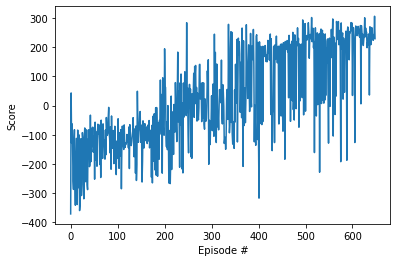

In [14]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    env = gym.wrappers.Monitor(gym.make(atari_game), 'output', force=True)
    render = True
    for i_episode in range(0, n_episodes):
        if render and i_episode % 100 == 0:
            env = gym.wrappers.Monitor(gym.make(atari_game), 'output_%d' % i_episode, force=True)
            state = env.reset()
        else:
            state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            if t%100==0:
                action = 1
            if render and i_episode % 100 == 0:
                env.render()
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if render:
                env.close()
                show_video('output_%d' % i_episode)
                env = gym.make(atari_game)
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            print("SOLVED!!!!!!")
            break
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores


agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0)
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

You can load the parameter by this line.

In [15]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    for j in range(200):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 

## Policy gradient 

This one is implemented in pure Python. 

### Define PG functions

In [16]:
import gym
atari_game = "LunarLander-v2"#"CartPole-v0"
env = gym.make(atari_game)

import numpy as np

class LogisticPolicy:
    
    def __init__(self, θ, α, γ):
        # Initialize paramters θ, learning rate α and discount factor γ
        
        self.θ = θ
        self.α = α
        self.γ = γ
        
    def logistic(self, y):
        # definition of logistic function
        
        return 1/(1 + np.exp(-y))
    
    def probs(self, x):
        # returns probabilities of two actions
        
        y = x @ self.θ
        prob0 = self.logistic(y)
        
        return np.array([prob0, 1-prob0])        
    
    def act(self, x):
        # sample an action in proportion to probabilities
        
        probs = self.probs(x)
        action = np.random.choice([0, 1], p=probs)
        
        return action, probs[action]
    
    def grad_log_p(self, x):
        # calculate grad-log-probs
        
        y = x @ self.θ        
        grad_log_p0 = x - x*self.logistic(y)
        grad_log_p1 = - x*self.logistic(y)
        
        return grad_log_p0, grad_log_p1
        
    def grad_log_p_dot_rewards(self, grad_log_p, actions, discounted_rewards):
        # dot grads with future rewards for each action in episode
        
        return grad_log_p.T @ discounted_rewards
    
    def discount_rewards(self, rewards):
        # calculate temporally adjusted, discounted rewards
        
        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.γ + rewards[i]
            discounted_rewards[i] = cumulative_rewards
            
        return discounted_rewards

    def update(self, rewards, obs, actions):
        # calculate gradients for each action over all observations
        grad_log_p = np.array([self.grad_log_p(ob)[action] for ob,action in zip(obs,actions)])
        
        assert grad_log_p.shape == (len(obs), 4)
        
        # calculate temporaly adjusted, discounted rewards
        discounted_rewards = self.discount_rewards(rewards)
        
        # gradients times rewards
        dot = self.grad_log_p_dot_rewards(grad_log_p, actions, discounted_rewards)
        
        # gradient ascent on parameters
        self.θ += self.α*dot
    
def run_episode(env, policy, render=False):
    
    observation = env.reset()
    totalreward = 0
    
    observations = []
    actions = []
    rewards = []
    probs = []
    
    done = False
    
    while not done:
        if render:
            env.render()
        
        observations.append(observation)
        
        action, prob = policy.act(observation)
        observation, reward, done, info = env.step(action)
        
        totalreward += reward
        rewards.append(reward)
        actions.append(action)
        probs.append(prob)
    
    return totalreward, np.array(rewards), np.array(observations), np.array(actions), np.array(probs)

def train(θ, α, γ, Policy, MAX_EPISODES=1000, seed=None, evaluate=False):
    
    # initialize environment and policy
    env = gym.make('CartPole-v0')
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    policy = Policy(θ, α, γ)
    
    # train until MAX_EPISODES
    for i in range(MAX_EPISODES):

        # run a single episode
        total_reward, rewards, observations, actions, probs = run_episode(env, policy)
                
        # keep track of episode rewards
        episode_rewards.append(total_reward)
        
        # update policy
        policy.update(rewards, observations, actions)
        print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False) 

    # evaluation call after training is finished - evaluate last trained policy on 100 episodes
    if evaluate:
        env = Monitor(env, 'pg_cartpole/', video_callable=False, force=True)
        for _ in range(100):
            run_episode(env, policy, render=False)
        env.env.close()
        
    return episode_rewards, policy

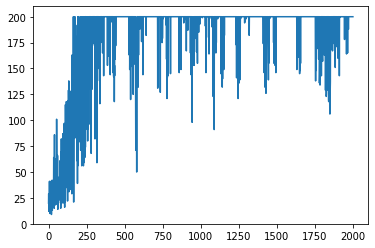

In [9]:
from gym.wrappers.monitor import Monitor, load_results

# for reproducibility
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

episode_rewards, policy = train(θ=np.random.rand(4),
                                α=0.002,
                                γ=0.99,
                                Policy=LogisticPolicy,
                                MAX_EPISODES=2000,
                                seed=GLOBAL_SEED,
                                evaluate=True)
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(episode_rewards);
results = load_results('pg_cartpole')
plt.hist(results['episode_rewards'], bins=20);